## Pre-Trained Model Evaluation

In [1]:
import sys
import torch
from pytorch_transformers import *
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
import json
from bert_serving.client import BertClient
import tensorflow as tf
import csv
import json
import itertools
import re
import random
import matplotlib.pyplot as plt

W0718 20:27:31.051425 140448560539392 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow_hub/native_module.py:54: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.

W0718 20:27:31.055280 140448560539392 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow_hub/__init__.py:65: The name tf.VERSION is deprecated. Please use tf.version.VERSION instead.



### Download the bert model
Open a terminal and download the BERT model. You only need to do this once. Run the command blow to download the model. Note that you may need to use the smaller base model depending on the resources you have to run this notebook.

### Unzip the model directory
Unzip the downloaded file in the same temrinal you downloaded the model.

### Run the BERT workers
In your terminal run the following command to start up a BERT server

### Read in the baseline queries

In [2]:
qs_file = './sample_questions.csv'
base_qs = pd.read_csv(qs_file)
base_qs.head(n=10)

,Saved Query,New Query
0,I really do not like this product,I really like this product
1,Where can I view my settings,I can't find the settings page
2,How much will this cost?,Is this expensive?
3,How do I change my password,change How I do password my
4,Blah blah blah blah,Can I get some help?
5,"Hello, is there anyone there?",Does this integrate with gmail?
6,Where is your data stored?,How secure is your product
7,What temperature is it today?,What time is the film in the cinema
8,Can I sign up for a free trial,Do I need a credit card to get started?
9,What is the Capital of Ireland?,What time is the game on?


### Download the USE module from TF Hub

In [3]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/3" 
embed = hub.Module(module_url)

W0718 20:27:31.442139 140448560539392 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow_hub/module.py:104: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0718 20:27:31.462398 140448560539392 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow_hub/resolver.py:73: The name tf.logging.log_first_n is deprecated. Please use tf.compat.v1.logging.log_first_n instead.

W0718 20:27:31.463221 140448560539392 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow_hub/resolver.py:73: The name tf.logging.INFO is deprecated. Please use tf.compat.v1.logging.INFO instead.

W0718 20:27:31.464453 140448560539392 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow_hub/resolver.py:80: The name tf.gfil

### Download the ELMO module

In [4]:
elmo_module_url = "https://tfhub.dev/google/elmo/2"
elmo_embed = hub.Module(elmo_module_url)

### Download the XLnet model via pytorch

In [5]:
config = XLNetConfig.from_pretrained('xlnet-large-cased')
tokenizer = XLNetTokenizer.from_pretrained('xlnet-large-cased')
model = XLNetModel(config)
model.eval()

XLNetModel(
  (word_embedding): Embedding(32000, 1024)
  (layer): ModuleList(
    (0): XLNetLayer(
      (rel_attn): XLNetRelativeAttention(
        (layer_norm): XLNetLayerNorm()
        (dropout): Dropout(p=0.1)
      )
      (ff): XLNetFeedForward(
        (layer_norm): XLNetLayerNorm()
        (layer_1): Linear(in_features=1024, out_features=4096, bias=True)
        (layer_2): Linear(in_features=4096, out_features=1024, bias=True)
        (dropout): Dropout(p=0.1)
      )
      (dropout): Dropout(p=0.1)
    )
    (1): XLNetLayer(
      (rel_attn): XLNetRelativeAttention(
        (layer_norm): XLNetLayerNorm()
        (dropout): Dropout(p=0.1)
      )
      (ff): XLNetFeedForward(
        (layer_norm): XLNetLayerNorm()
        (layer_1): Linear(in_features=1024, out_features=4096, bias=True)
        (layer_2): Linear(in_features=4096, out_features=1024, bias=True)
        (dropout): Dropout(p=0.1)
      )
      (dropout): Dropout(p=0.1)
    )
    (2): XLNetLayer(
      (rel_attn): X

### Find the similarity using angular distance
Angular distance is a form of cosine similarity

In [6]:
sts_input1 = tf.placeholder(tf.float64, shape=(None))
sts_input2 = tf.placeholder(tf.float64, shape=(None))

# For evaluation we use exactly normalized rather than
# approximately normalized.
sts_encode1 = tf.nn.l2_normalize((sts_input1), axis=1)
sts_encode2 = tf.nn.l2_normalize((sts_input2), axis=1)

cosine_similarities = tf.reduce_sum(tf.multiply(sts_encode1, sts_encode2), axis=1)
clip_cosine_similarities = tf.clip_by_value(cosine_similarities, 0.0, 1.0)
sim_scores = 1.0 - tf.divide(tf.acos(clip_cosine_similarities), 3.14)

def get_scores(session, text_a, text_b):
    """Returns the similarity scores"""
    emba, embb, scores= session.run(
        [sts_encode1, sts_encode2, sim_scores],
        feed_dict={
            sts_input1: text_a,
            sts_input2: text_b
        })
    return(emba, embb, scores)

### Create a function to print a graph comparing the results

In [7]:
def generate_graph(df, file_name):
    bert = [r*100 for r in df['BERT Score']]
    use = [r*100 for r in df['USE Score']]
    elmo = [r*100 for r in df['ELMO Score']]
    xlnet = [r*100 for r in df['XLNet Score']]
    
    
    plt.figure(figsize=(12, 8))
    rank = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    
    plt.xlim([1, 10])
    plt.ylim([40, 100])
    plt.plot(rank, bert, color='green')
    plt.plot(rank, use, color='orange')
    plt.plot(rank, elmo, color='blue')
    plt.plot(rank, xlnet, color='red')
    plt.xlabel("Ranking")
    plt.ylabel('Cosine similarity')
    plt.title("Score comparison")
    plt.legend(["bert", "use", "elmo", "xlnet"], loc=4)
    plt.savefig(file_name)
    plt.show()

### Create an interactive TF session

In [8]:
session = tf.InteractiveSession()
session.run(tf.global_variables_initializer())
session.run(tf.tables_initializer())

### Find the most similar sentences using BERT embeddings

In [9]:
results = []
queries = [q for q in base_qs['Saved Query']]
examples = [e for e in base_qs['New Query']]
bc = BertClient(check_length=False)
example_emb = bc.encode(examples)

for i, q in enumerate(queries):
    
    # Get the BERT embeddings score and find the best matching sentences
    new_emb = bc.encode([q])
    emba, embb, sim_score = get_scores(session, 
                                       new_emb.tolist(), 
                                       example_emb.tolist())
    base_qs['Score'] = sim_score
    sort_df = base_qs.sort_values('Score', ascending=False)
    best = sort_df.head(n=1)
    ans = (best['New Query']).tolist()[0]
    
    # Get the USE embeddings score for the matching sentences
    use1, useb, use_score = get_scores(session, 
                                       session.run(embed([q])), 
                                       session.run(embed([ans])))
    
    # Get the ELMO embeddings score for the matching sentences
    elmo1, elmo2, elmo_score = get_scores(session, 
                                          session.run(elmo_embed([q])), 
                                          session.run(elmo_embed([ans])))
    
    # Get the XLNet embeddings score for the matvhing sentences
    xlnet_q = torch.tensor(tokenizer.encode(q)).unsqueeze(0)
    xlnet_ans = torch.tensor(tokenizer.encode(ans)).unsqueeze(0)
    output_q = model(xlnet_q)
    output_ans = model(xlnet_ans)
    xln1, xln2, xlnet_score = get_scores(session, 
                                         [output_q[0][0][1].tolist()], 
                                         [output_ans[0][0][1].tolist()])


    print("Result {}:\nQuestion {}\nBest Match {}".format(i+1, q, ans))  
    results.append([q, ans, np.round((best['Score']).tolist()[0], 3), 
                    np.round(use_score.tolist()[0], 3), 
                    np.round(elmo_score.tolist()[0], 3),
                    np.round(xlnet_score.tolist()[0], 3)])
    df = pd.DataFrame(results, columns=['Saved Query', 'New Query', 'BERT Score', 'USE Score', 'ELMO Score', 'XLNet Score'])

Result 1:
Question I really do not like this product
Best Match I really like this product
Result 2:
Question Where can I view my settings
Best Match Does this integrate with gmail?
Result 3:
Question How much will this cost?
Best Match Is this expensive?
Result 4:
Question How do I change my password
Best Match I can't find the settings page
Result 5:
Question Blah blah blah blah
Best Match Does this integrate with gmail?
Result 6:
Question Hello, is there anyone there?
Best Match What time is the game on?
Result 7:
Question Where is your data stored?
Best Match How secure is your product
Result 8:
Question What temperature is it today?
Best Match What time is the game on?
Result 9:
Question Can I sign up for a free trial
Best Match Do I need a credit card to get started?
Result 10:
Question What is the Capital of Ireland?
Best Match What time is the film in the cinema


In [10]:
df = df.sort_values('BERT Score', ascending=False)
df.index = np.arange(1,len(df)+1)
df


,Saved Query,New Query,BERT Score,USE Score,ELMO Score,XLNet Score
1,How much will this cost?,Is this expensive?,0.892,0.803,0.742,0.720
2,Where is your data stored?,How secure is your product,0.890,0.625,0.765,0.705
3,What temperature is it today?,What time is the game on?,0.880,0.677,0.746,0.730
4,How do I change my password,I can't find the settings page,0.868,0.671,0.717,0.706
5,Can I sign up for a free trial,Do I need a credit card to get started?,0.868,0.736,0.753,0.759
6,Where can I view my settings,Does this integrate with gmail?,0.866,0.620,0.717,0.691
7,I really do not like this product,I really like this product,0.865,0.747,0.864,0.870
8,What is the Capital of Ireland?,What time is the film in the cinema,0.865,0.578,0.663,0.778
9,"Hello, is there anyone there?",What time is the game on?,0.832,0.594,0.680,0.723
10,Blah blah blah blah,Does this integrate with gmail?,0.765,0.519,0.585,0.688


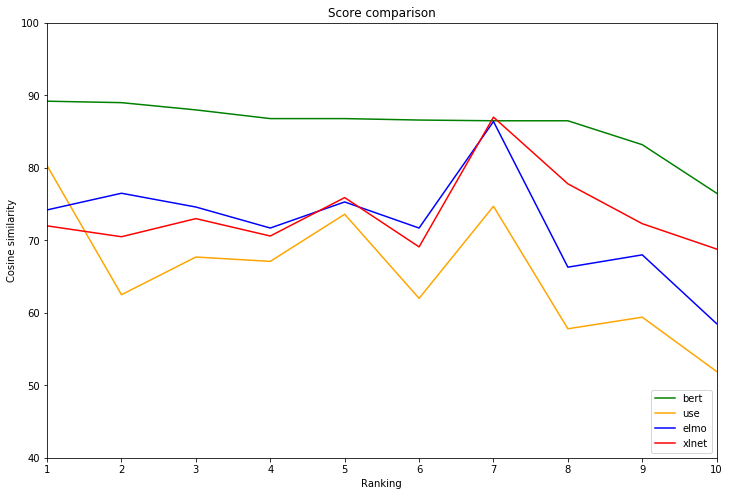

In [11]:
generate_graph(df, "bert_model_comparison")

In [ ]:
results = []
queries = [q for q in base_qs['Saved Query']]
examples = [e for e in base_qs['New Query']]
bc = BertClient(check_length=False)

for i, q in enumerate(queries):
    
    # Get the USE embeddings score for the matching sentences
    use1, useb, use_score = get_scores(session, session.run(embed([q])), session.run(embed(examples)))
    
    base_qs['Score'] = use_score
    sort_df = base_qs.sort_values('Score', ascending=False)
    best = sort_df.head(n=1)
    ans = (best['New Query']).tolist()[0]
    
    # Get the ELMO embeddings score for the matching sentences
    elmo1, elmo2, elmo_score = get_scores(session, session.run(elmo_embed([q])), session.run(elmo_embed([ans])))
    # Get the BERT embeddings score and find the best matching sentences
    new_emb = bc.encode([q])
    save_emb = bc.encode([ans])
    emba, embb, bert_score = get_scores(session, new_emb.tolist(), save_emb.tolist())
    
    # Get the XLNet embeddings score for the matvhing sentences
    xlnet_q = torch.tensor(tokenizer.encode(q)).unsqueeze(0)
    xlnet_ans = torch.tensor(tokenizer.encode(ans)).unsqueeze(0)
    output_q = model(xlnet_q)
    output_ans = model(xlnet_ans)
    xln1, xln2, xlnet_score = get_scores(session, 
                                         [output_q[0][0][1].tolist()], 
                                         [output_ans[0][0][1].tolist()])
    
    print("{}: {}: {}: {}".format(q, ans, use_score, elmo_score))  
    results.append([q, ans, np.round(elmo_score.tolist()[0], 3), 
                    np.round(use_score.tolist()[0], 3), 
                    np.round((best['Score']).tolist()[0], 3),
                    np.round(xlnet_score.tolist()[0], 3)])
    df = pd.DataFrame(results, columns=['Saved Query', 'New Query', 'USE Score', 'BERT Score', 'ELMO Score', 'XLNet Score'])

I really do not like this product: I really like this product: [0.74743642 0.56324132 0.61801848 0.54669346 0.59655949 0.5268201
 0.58462825 0.49974639 0.55162396 0.49974639]: [0.86375383]
Where can I view my settings: I can't find the settings page: [0.54152227 0.82407737 0.52529959 0.64732134 0.59830295 0.62034671
 0.54166945 0.60852898 0.56436388 0.62029246]: [0.71781397]
How much will this cost?: Is this expensive?: [0.59793322 0.56694558 0.80324722 0.52709434 0.61297099 0.57004207
 0.60277072 0.61415834 0.64619797 0.59590248]: [0.74247178]
How do I change my password: change How I do password my: [0.53757991 0.67064965 0.52552733 0.88330973 0.62440804 0.6250195
 0.61467375 0.56159662 0.64845157 0.58505201]: [0.81114471]
Blah blah blah blah: Can I get some help?: [0.58631497 0.50521383 0.53215951 0.54350224 0.63920364 0.5191529
 0.49974639 0.49974639 0.51740571 0.52475955]: [0.58128593]
Hello, is there anyone there?: Can I get some help?: [0.55921744 0.54919871 0.56503569 0.5612873

In [ ]:
df = df.sort_values('USE Score', ascending=False)
df.index = np.arange(1,len(df)+1)
df

In [ ]:
generate_graph(df, "use_model_comparison")